In [8]:
import csv
from datetime import timedelta
import gurobipy as gp 
from gurobipy import GRB
import networkx as nx
import random
import matplotlib.pyplot as plt
import inspect
from collections import defaultdict

from models import simple_mpc, mpc_duration_constr, lazy, column_generation
from helper import Service, hhmm2mins, mins2hhmm, fetch_data, draw_graph_with_edges, node_legal, no_overlap, create_duty_graph, extract_nodes, generate_paths, roster_statistics, solution_verify, solve_RMLP, new_duty_with_bellman_ford

In [9]:
import importlib
import models
import helper

importlib.reload(models)
importlib.reload(helper)

from models import simple_mpc, mpc_duration_constr, lazy, column_generation
from helper import Service, hhmm2mins, mins2hhmm, fetch_data, draw_graph_with_edges, node_legal, no_overlap, create_duty_graph, extract_nodes, generate_paths, roster_statistics, solution_verify, solve_RMLP, new_duty_with_bellman_ford

In [10]:
services, service_dict = fetch_data('./StepBackServices.csv', partial=False, rakes=2)       # 46 maximum number of rakes
graph = create_duty_graph(services)
print(graph)

DiGraph with 936 nodes and 33542 edges


In [11]:
init_duties, duty_count = mpc_duration_constr(graph, service_dict, time_limit = 30, show_logs = True, show_duties = False, show_roster_stats = True)
init_duties2 = init_duties.copy()

Set parameter TimeLimit to value 30
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 104364 rows, 68020 columns and 335422 nonzeros
Model fingerprint: 0x4522e447
Variable types: 34478 continuous, 33542 integer (33542 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]
Presolve removed 4053 rows and 1231 columns
Presolve time: 1.19s
Presolved: 100311 rows, 66789 columns, 375048 nonzeros
Variable types: 33433 continuous, 33356 integer (33356 binary)
Found heuristic solution: objective 899.0000000
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: obje

In [33]:
objectives, selected_duty_vars = column_generation(method=1, graph = graph, services = services, init_duties= init_duties2, num_iter = 100, threshold=0.5) 

Iteration 0
Optimal solution found
Objective Value: 98.56724932475406
Iteration 1
Optimal solution found
Objective Value: 98.5480421045116
Iteration 2
Optimal solution found
Objective Value: 98.51479587854725
Iteration 3
Optimal solution found
Objective Value: 98.49262462869045
Iteration 4
Optimal solution found
Objective Value: 98.45855787968937
Iteration 5
Optimal solution found
Objective Value: 98.42494700561339
Iteration 6
Optimal solution found
Objective Value: 98.39063496566978
Iteration 7
Optimal solution found
Objective Value: 98.37126054048352
Iteration 8
Optimal solution found
Objective Value: 98.34408690260456
Iteration 9
Optimal solution found
Objective Value: 98.32268046291557
Iteration 10
Optimal solution found
Objective Value: 98.288276420272
Iteration 11
Optimal solution found
Objective Value: 98.25210366880114
Iteration 12
Optimal solution found
Objective Value: 98.22937174877613
Iteration 13
Optimal solution found
Objective Value: 98.1944580268717
Iteration 14
Optimal

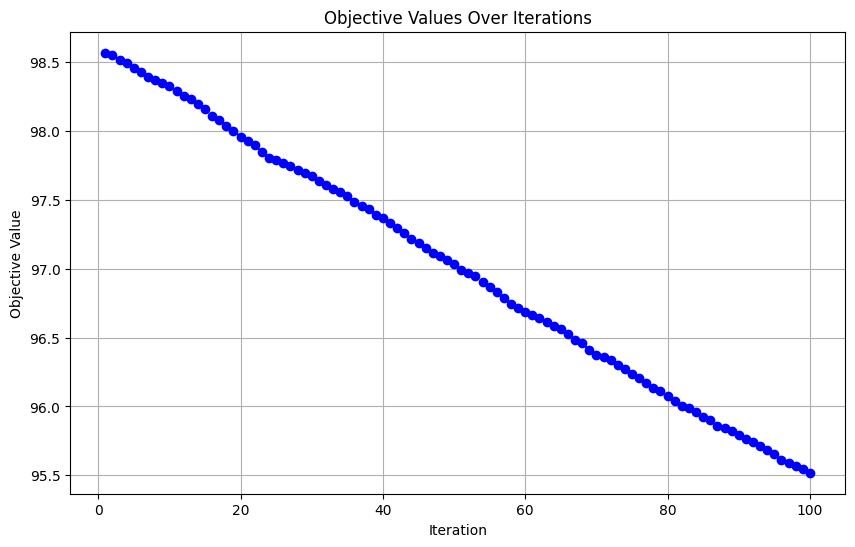

In [34]:
iterations = range(1, len(objectives) + 1)

plt.figure(figsize=(10, 6))
plt.plot(iterations, objectives, marker='o', linestyle='--', color='b')
plt.title('Objective Values Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.grid(True)
plt.show()

In [ ]:
# to check number of services that overlap in all selected duties
# run after column generation

indexes = [int(duty_num[1:]) for duty_num in selected_duty_vars[-1]]

matching_duties = [init_duties2[i] for i in indexes]

services_covered = {}
for duty in matching_duties:
    for service in duty:
        if service not in services_covered:
            services_covered[service] = 1
        else:
            services_covered[service] += 1
print(services_covered)

num_overlaps = 0
for service in services_covered:
    if services_covered[service] > 1:
        num_overlaps += 1
print(num_overlaps)
print(services_covered[-2])
print(services_covered[-1])

{873: 1, 347: 1, 38: 1, 79: 1, 399: 1, 527: 1, 538: 1, 547: 1, 557: 1, 566: 1, 576: 1, 589: 1, 597: 1, 612: 1, 620: 1, 629: 1, 638: 1, 647: 1, 656: 1, 664: 1, 673: 1, 926: 1, 533: 1, 540: 1, 549: 1, 558: 1, 567: 1, 575: 1, 583: 1, 591: 1, 599: 1, 607: 1, 615: 1, 623: 1, 632: 1, 641: 1, 650: 1, 659: 1, 669: 1, 678: 1, 683: 1, 528: 1, 534: 1, 544: 1, 553: 1, 562: 1, 571: 1, 580: 1, 588: 1, 603: 1, 611: 1, 619: 1, 627: 1, 636: 1, 645: 1, 654: 1, 662: 1, 670: 1, 684: 1, 529: 1, 535: 1, 543: 1, 552: 1, 561: 1, 570: 1, 579: 1, 587: 1, 596: 1, 605: 1, 614: 1, 624: 1, 633: 1, 642: 1, 651: 1, 660: 1, 668: 1, 682: 1, 530: 1, 542: 1, 551: 1, 560: 1, 569: 1, 578: 1, 586: 1, 594: 1, 602: 1, 610: 1, 618: 1, 628: 1, 637: 1, 646: 1, 655: 1, 666: 1, 674: 1, 689: 1, 339: 1, 20: 1, 725: 1, 73: 1, 397: 1, 531: 1, 537: 1, 546: 1, 555: 1, 564: 1, 573: 1, 581: 1, 590: 1, 598: 1, 606: 1, 621: 1, 630: 1, 639: 1, 648: 1, 657: 1, 665: 1, 676: 1, 686: 1, 342: 1, 26: 1, 730: 1, 83: 1, 402: 1, 343: 1, 64: 1, 749: 1